In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Siemens Work/pytorch_custom_yolo_training'    #project folder directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd 'gdrive/My Drive/Siemens Work/pytorch_custom_yolo_training'

/content/gdrive/My Drive/Siemens Work/pytorch_custom_yolo_training


In [3]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from numpy import asarray

In [4]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.9
nms_thres=0.1

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [5]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 1, conf_thres, nms_thres)
    return detections[0]

**Splitting image into 9 equal parts(3x3)**

In [18]:
img = Image.open('images/split/testing.jpg')
im = asarray(img)

M = im.shape[0]//3
N = im.shape[1]//3                 
image_paths = []
count = 0
for x in range(0,im.shape[0],M):
  for y in range(0,im.shape[1],N):
     if ((im.shape[0]-x < 2) | (im.shape[1]-y < 2)):  #leaving out images, which are long and skinny
        continue
     else:
        count = count + 1
        tile = im[x:x+M,y:y+N]
        Image.fromarray(tile).save('images/split/' + str(count) + '.jpg')

        image_paths.append('images/split/' + str(count) + '.jpg')

**Load image and get detections for splitted images**

Inference Time: 0:00:00.065082
No detections


<Figure size 432x288 with 0 Axes>

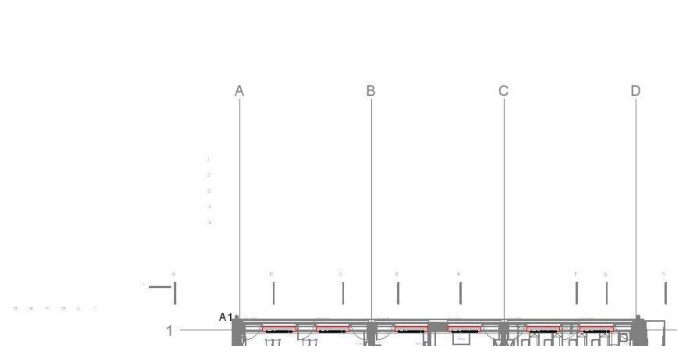

Inference Time: 0:00:00.057785


<Figure size 432x288 with 0 Axes>

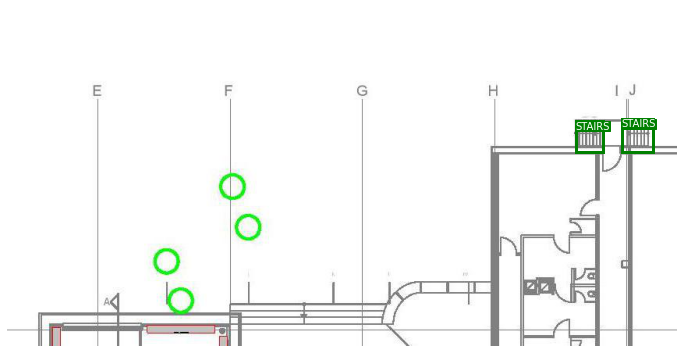

Inference Time: 0:00:00.061658
No detections


<Figure size 432x288 with 0 Axes>

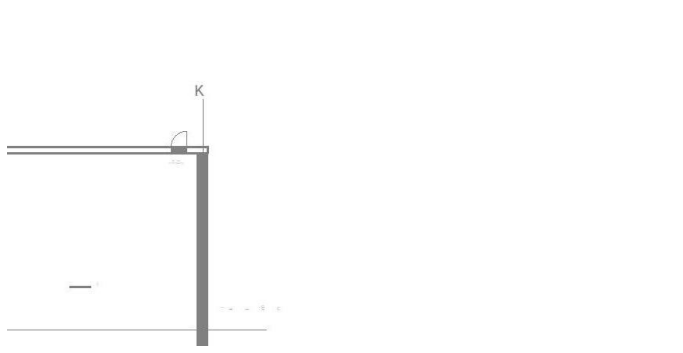

Inference Time: 0:00:00.056901


<Figure size 432x288 with 0 Axes>

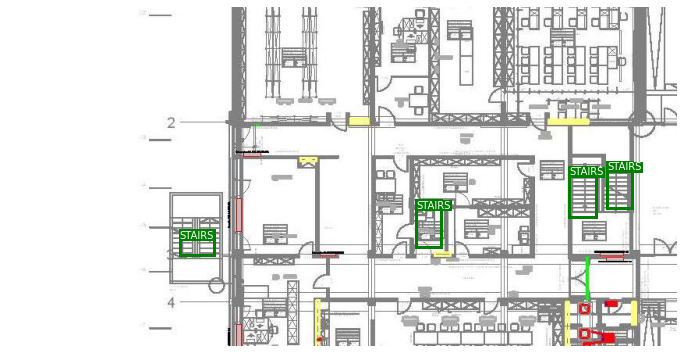

Inference Time: 0:00:00.062668


<Figure size 432x288 with 0 Axes>

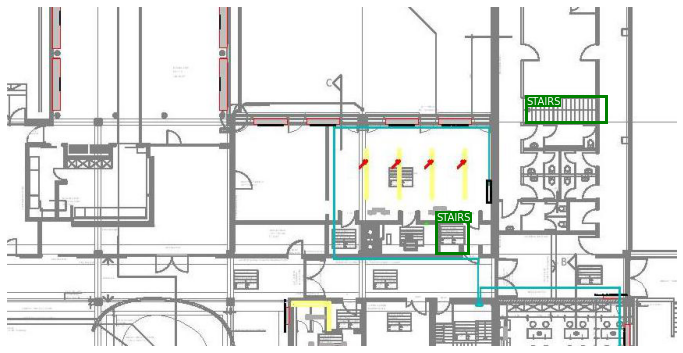

Inference Time: 0:00:00.062446


<Figure size 432x288 with 0 Axes>

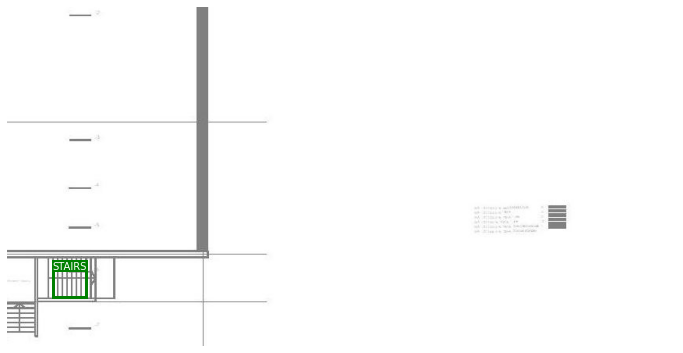

Inference Time: 0:00:00.057741


<Figure size 432x288 with 0 Axes>

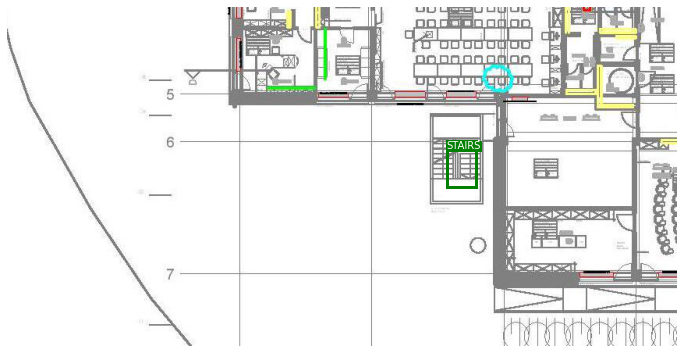

Inference Time: 0:00:00.068273


<Figure size 432x288 with 0 Axes>

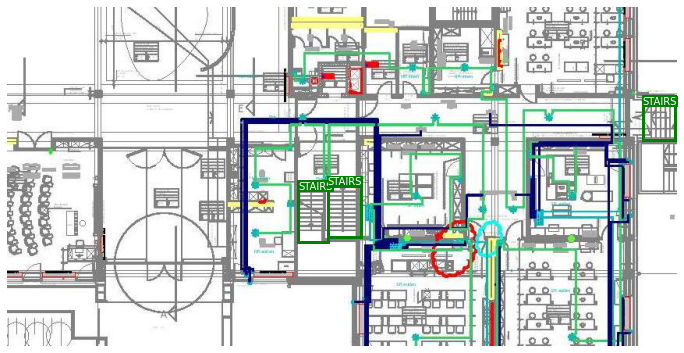

Inference Time: 0:00:00.067083


<Figure size 432x288 with 0 Axes>

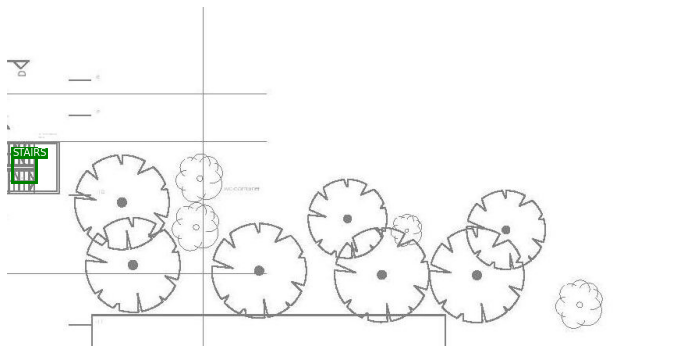

In [19]:
for file_ in image_paths:
  img_path = file_
  prev_time = time.time()
  img = Image.open(img_path)
  img = img.convert('RGB')
  detections = detect_image(img)
  inference_time = datetime.timedelta(seconds=time.time() - prev_time)
  print ('Inference Time: %s' % (inference_time))
  if detections is None:
   print('No detections')
# Get bounding-box colors
#cmap = plt.get_cmap('tab20b')
#colors = [cmap(i) for i in np.linspace(0, 1, 20)]


  img = np.array(img)
  plt.figure()
  fig, ax = plt.subplots(1, figsize=(12,9))
  ax.imshow(img)

  pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
  pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
  unpad_h = img_size - pad_y
  unpad_w = img_size - pad_x
  
  if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    #bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        #color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor='green', facecolor='none')
        ax.add_patch(bbox)
      
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': 'green', 'pad': 0})
  plt.axis('off')
# save image
  plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
  plt.show()


**Merge the smaller detected images to get full detected image**

In [16]:
import cv2 as cv
from google.colab.patches import cv2_imshow

range_x = im.shape[0]//M
range_y = im.shape[1]//N

count = 0
detected_img = Image.open(image_paths[count].replace(".jpg", "-det.jpg"))
w = detected_img.size[0]
h = detected_img.size[1]
f_w = w*range_x
f_h = h*range_y
final_detected_img = Image.new('RGB', (f_w,f_h))

for x in range(range_x):
  for y in range(range_y):
        detected_img = Image.open(image_paths[count].replace(".jpg", "-det.jpg"))
        final_detected_img.paste(detected_img, (w*y,h*x))
        count = count + 1

In [17]:
final_detected_img.save("images/split/final_detected_img.jpg")